In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplhep
import uncertainties as unc

plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"


In [3]:
def process_mc_data(file_path):
    df = uproot.open(f"{file_path}:rec511")
    df = df.arrays(library='pd')
    mc_cut = df.query('NNPass==1')
    mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
    return mc_cut_best_candidate
    
mc_cut_best_candidate_signal = process_mc_data(file_signal)
mc_cut_best_candidate_background = process_mc_data(file_bkg)

included_q2reg_values = [1, 2, 3, 4]
excluded_q2reg_values = [11, 12]
mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')


signal =mc_q2cut_signal["PIDCorrectionAndAcceptanceWeight"]
bkg = mc_q2cut_background["PIDCorrectionAndAcceptanceWeight"]

print(len(signal))
print(len(bkg))

14388
2725


In [18]:
class trimVars():
    @staticmethod
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 == 4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 != 4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df
    
    @staticmethod
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    @staticmethod
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df

def process_MC_data_combined(file_path_signal, file_path_background, particle_type, Btree, pi, ll, q2):
    def process_mc_data(file_path, q2):
        df = uproot.open(f"{file_path}:rec511")
        df = df.arrays(library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate

    mc_cut_best_candidate_signal = process_mc_data(file_path_signal, q2)
    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2)

    if q2 == 11 or q2 == 12:
        mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")

        if particle_type == 'ele':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 511 and Kst_isSignal == 1 and abs(lm_PDG) == 11 and abs(lp_PDG) == 11 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        elif particle_type == 'mu':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 511 and Kst_isSignal == 1 and abs(lm_PDG) == 13 and abs(lp_PDG) == 13 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        else:
            raise ValueError(f"Unknown particle_type: {particle_type}")

        deltaE_range = (-0.15, 0.15)

        mc_signal_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(cut)
        mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_bkg_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(f'not ({cut})')
        mc_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_Continuum_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst.query('isContinuumEvent==1')
        mc_Bmeson_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst.query('isContinuumEvent!=1')

        mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_bkg_weight_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_Continuum_bkg_weight_q2cut_jpsi_kst = mc_Continuum_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_Bmeson_bkg_weight_q2cut_jpsi_kst = mc_Bmeson_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]

        # Data
        mc_signal_data = mc_signal_q2cut_jpsi_kst
        mc_bkg_data = mc_bkg_q2cut_jpsi_kst
        mc_Continuum_bkg_data = mc_Continuum_bkg_q2cut_jpsi_kst
        mc_Bmeson_bkg_data = mc_Bmeson_bkg_q2cut_jpsi_kst
        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_bkg_weight = mc_bkg_weight_q2cut_jpsi_kst
        mc_Continuum_bkg_weight = mc_Continuum_bkg_weight_q2cut_jpsi_kst
        mc_Bmeson_bkg_weight = mc_Bmeson_bkg_weight_q2cut_jpsi_kst

        return mc_signal_data, mc_bkg_data, mc_Continuum_bkg_data, mc_Bmeson_bkg_data, mc_signal_weight, mc_bkg_weight, mc_Continuum_bkg_weight, mc_Bmeson_bkg_weight

    else:
        if q2 in [1, 2, 3, 4]:
            excluded_q2reg_values = [11, 12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f"q2reg == {q2}")
            mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")
        elif q2 == 0:
            included_q2reg_values = [1, 2, 3, 4,11,12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values}')
            mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values}')
        else:
            raise ValueError("Invalid q2 value")

        deltaE_range = (-0.15, 0.15)

        mc_particle_type_signal = mc_q2cut_signal.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_only_signal = mc_particle_type_signal.query('isSignal==1')
        mc_particle_type_scf = mc_particle_type_signal.query('isSignal==0')

        mc_particle_type_bkg = mc_q2cut_background.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_Continuum_bkg = mc_particle_type_bkg.query('isContinuumEvent==1')
        mc_particle_type_Bmeson_bkg = mc_particle_type_bkg.query('isContinuumEvent!=1')

        mc_particle_type_signal_weight = mc_particle_type_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_only_signal_weight = mc_particle_type_only_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_scf_weight = mc_particle_type_scf["PIDCorrectionAndAcceptanceWeight"]

        mc_particle_type_bkg_weight = mc_particle_type_bkg["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_Continuum_bkg_weight = mc_particle_type_Continuum_bkg["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_Bmeson_bkg_weight = mc_particle_type_Bmeson_bkg["PIDCorrectionAndAcceptanceWeight"]

        return (mc_particle_type_signal, mc_particle_type_only_signal, mc_particle_type_scf,
                mc_particle_type_bkg, mc_particle_type_Continuum_bkg, mc_particle_type_Bmeson_bkg,
                mc_particle_type_signal_weight, mc_particle_type_only_signal_weight, mc_particle_type_scf_weight,
                mc_particle_type_bkg_weight, mc_particle_type_Continuum_bkg_weight, mc_particle_type_Bmeson_bkg_weight)


In [19]:
mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_Continuum_bkg, mc_ele_Bmeson_bkg,mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight, mc_ele_Continuum_bkg_weight, mc_ele_Bmeson_bkg_weight =process_MC_data_combined(file_signal, file_bkg,'ele', 511, 'pip', 'ee', 0)


In [20]:
print(len(mc_ele_signal_weight))
print(len(bkg))

17204
2725


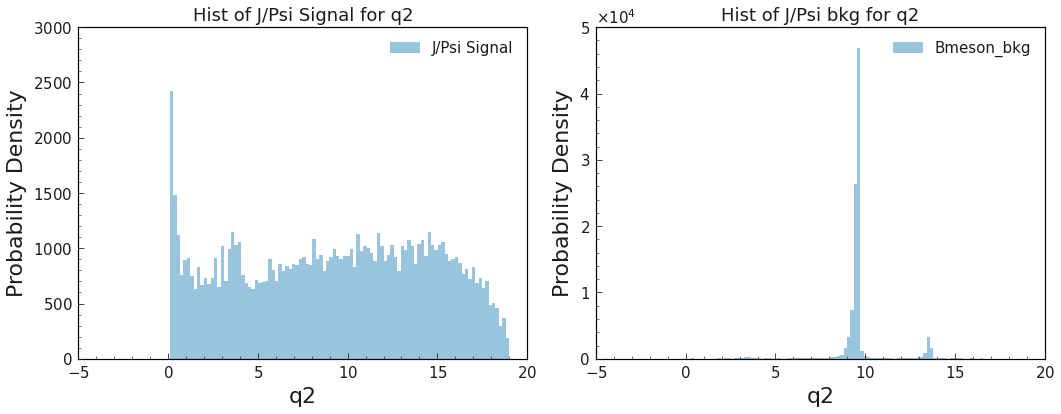

In [21]:
def plot_histogram(ax, data_dict, labels, data_weight, xlabel, ylabel, title):
    for label in labels:
        ax.hist(data_dict[label], weights=data_weight[label], bins=100, alpha=0.5, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_title(title)


# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


# q2_signal
plot_histogram(axs[0], {"J/Psi Signal": mc_ele_signal["q2"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_ele_signal_weight}, 'q2', 'Probability Density', 'Hist of J/Psi Signal for q2')

'''
# Mbc_signal
plot_histogram(axs[0, 0], {"J/Psi Signal": mc_ele_signal["Mbc"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_ele_signal_weight}, 'Mbc', 'Probability Density', 'Hist of J/Psi Signal for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Continuum_bkg": mc_ele_Continuum_bkg_data["Mbc"],
                           "Bmeson_bkg": mc_ele_Bmeson_bkg_data["Mbc"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# q2_bkg
plot_histogram(axs[1, 1], {"Continuum_bkg": mc_ele_Continuum_bkg_data["q2"],
                           "Bmeson_bkg": mc_ele_Bmeson_bkg_data["q2"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'q2', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Bmeson_bkg": mc_ele_Bmeson_bkg["Mbc"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')
'''
# q2_bkg
plot_histogram(axs[1], {
                           "Bmeson_bkg": mc_ele_Bmeson_bkg["q2"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'q2', 'Probability Density', 'Hist of J/Psi bkg for q2')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

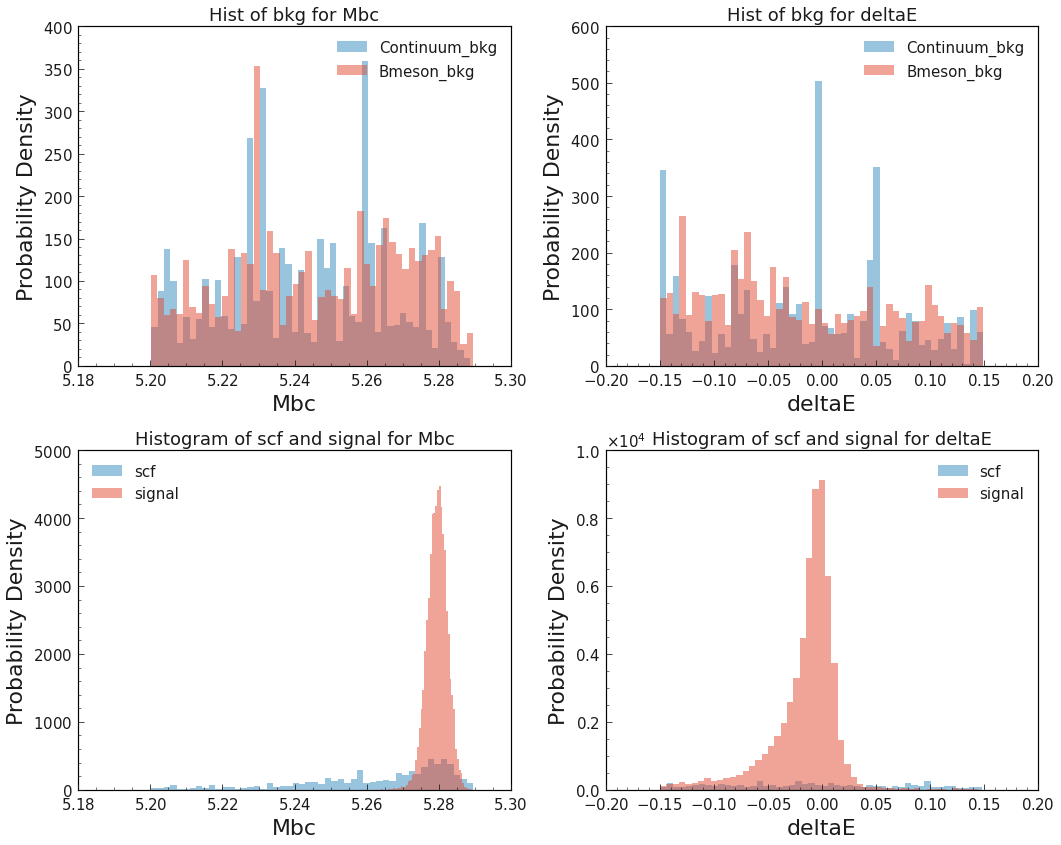

In [8]:
def plot_histogram(ax,bins, data_dict, labels, data_weight, xlabel, ylabel, title):
    for label in labels:
        ax.hist(data_dict[label], weights=data_weight[label], bins=bins, alpha=0.5, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_title(title)

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0],50, {"Continuum_bkg":  mc_ele_Continuum_bkg["Mbc"],
                           "Bmeson_bkg":  mc_ele_Bmeson_bkg["Mbc"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1],50, {"Continuum_bkg": mc_ele_Continuum_bkg["deltaE"],
                           "Bmeson_bkg": mc_ele_Bmeson_bkg["deltaE"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0],50, {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1],50, {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [9]:
obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))

## Fit ##

In [10]:
def fit(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type,q2reg):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    ratios_label_dataset_model_type = None
    
    
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.005)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 2)
        
        
        label_dataset_name_model_type = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
   
   
    elif model_type == 'cb_gauss':
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", -0.0)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.009)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.5)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)

        label_dataset_name_cb = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", -0.0)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.0096)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.1)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb, label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 1)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 5.279)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.005)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus,label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly, label_dataset_name_argus],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_model_type = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_ele_label_dataset_name_poly = zfit.Parameter(f'coeff0_ele_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_ele_label_dataset_name_poly = zfit.Parameter(f'coeff1_ele_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_model_type = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_ele_label_dataset_name_poly, coeff1_ele_label_dataset_name_poly])

        
        
    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_ele_label_dataset_name_poly = zfit.Parameter(f'coeff0_ele_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_ele_label_dataset_name_poly = zfit.Parameter(f'coeff1_ele_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_ele_label_dataset_name_poly, coeff1_ele_label_dataset_name_poly])

        # Gaussian
        mu_ele_label_dataset_name_gauss = zfit.Parameter(f"mu_ele_{label}_{dataset_name}_gauss_{r}", 0.0)
        sigma_ele_label_dataset_name_gauss = zfit.Parameter(f"sigma_ele_{label}_{dataset_name}_gauss_{r}", 0.008)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_ele_label_dataset_name_gauss, sigma=sigma_ele_label_dataset_name_gauss)
        
        # Fraction
        frac_ele_label_dataset_name_model_type = zfit.Parameter(f"frac_ele_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly,label_dataset_name_gauss],
            fracs=[frac_ele_label_dataset_name_model_type],
            obs=obs_label)
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
    data_label_dataset_name = zfit.data.Data.from_pandas(
    mc_dataset_name_data_label,
    obs=obs_label,
    weights=mc_dataset_name_weight_label
    )
   
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
    
    # Extract and save the parameter values
    parameters_values = {
        "_".join(param.name.split('_')[:-1]): param.numpy() for param in label_dataset_name_model_type.get_params()
    }

    ratios_label_dataset_model_type = pd.DataFrame(parameters_values, index=[0])
    ratios_label_dataset_model_type.to_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_{q2reg}.csv", index=False)
    
    return label_dataset_name_model_type, result_label_dataset_name


In [11]:
# signal
Mbc_only_signal_cb, result_Mbc_signal = fit('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss, result_deltaE_signal = fit('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)

#scf
Mbc_scf_argus_gauss, result_Mbc_scf = fit('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss, result_deltaE_scf = fit('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)

#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss, result_Mbc_Bmeson_bkg = fit('Mbc','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight,'argus',0)
deltaE_Bmeson_bkg_poly_gauss, result_deltaE_Bmeson_bkg = fit('deltaE','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,'poly_gauss',0)

#Continuum_bkg
Mbc_Continuum_bkg_argus, result_Mbc_Continuum_bkg = fit('Mbc','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight,'argus',0)
deltaE_Continuum_bkg_poly_gauss, result_deltaE_Continuum_bkg = fit('deltaE','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,'poly',0)


In [12]:
def plot_with_fit(ax,bins, data, data_weight, fitted_model, data_range, label_data, label_fit, xlabel, ylabel, title):
    # Calculate histogram
    n, bins, _ = ax.hist(data, bins=bins, weights=data_weight, density=False, alpha=0.5, label=label_data)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((data >= bins[i]) & (data < bins[i+1]))[0]
        bin_weights.append(data_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # De-normalization
    pdf_values = fitted_model.pdf(data_range).numpy() * sum(data_weight) * (bins[1] - bins[0])

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label=f'{label_data} with Error Bars')
    ax.plot(data_range, pdf_values, 'r', label=label_fit)

    # Add labels and title
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=15)
    return pdf_values

name                              value  (rounded)    at limit
------------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.4763                5.27967       False
sigma_ele_Mbc_signal_cb_0.4763          0.00266069       False
alpha_ele_Mbc_signal_cb_0.4763             1.84032       False
n_ele_Mbc_signal_cb_0.4763                 17.7094       False
True
name                                      value  (rounded)    at limit
--------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.5812            0.393085       False
mu_ele_deltaE_signal_cb_0.5812                  -0.0270729       False
sigma_ele_deltaE_signal_cb_0.5812                0.0362131       False
alpha_ele_deltaE_signal_cb_0.5812                  1.44555       False
n_ele_deltaE_signal_cb_0.5812                     0.787733       False
mu_ele_deltaE_signal_gauss_0.5812              -0.00394297       False
sigma_ele_deltaE_signal_gauss_0.5812             

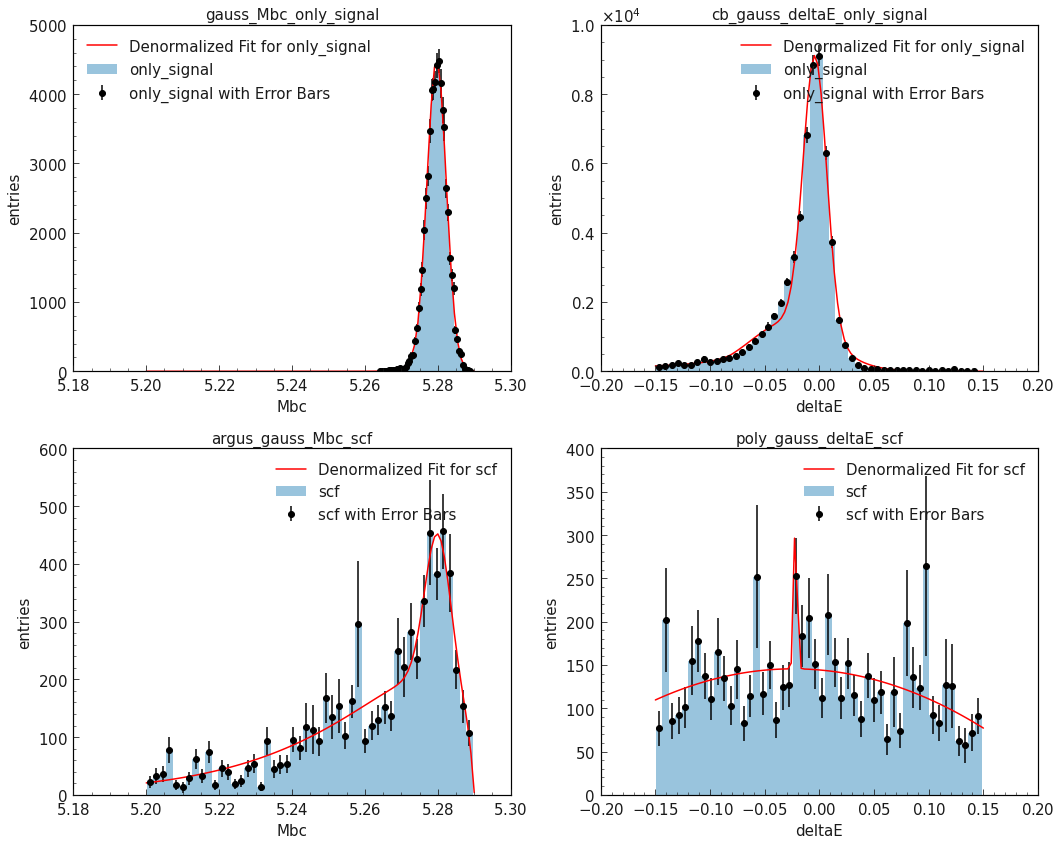

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0,0],50, mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 
                                           Mbc_only_signal_cb, Mbc_range, 
                                           'only_signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'gauss_Mbc_only_signal')


fit_model_deltaE_only_signal = plot_with_fit(axs[0,1],50, mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 
                                             deltaE_only_signal_cb_gauss, deltaE_range, 
                                             'only_signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

fit_model_Mbc_scf = plot_with_fit(axs[1,0],50, mc_ele_scf["Mbc"], mc_ele_scf_weight, 
                                            Mbc_scf_argus_gauss, Mbc_range, 
                                           'scf', 'Denormalized Fit for scf', 
                                           'Mbc', 'entries', 'argus_gauss_Mbc_scf')


fit_model_deltaE_scf = plot_with_fit(axs[1,1],50, mc_ele_scf["deltaE"], mc_ele_scf_weight, 
                                             deltaE_scf_poly_gauss, deltaE_range, 
                                             'scf', 'Denormalized Fit for scf', 
                                             'deltaE', 'entries', 'poly_gauss_deltaE_scf')




# Adjust layout
plt.tight_layout()


# Print results if needed
print(result_Mbc_signal.params)
print(result_Mbc_signal.valid)
print(result_deltaE_signal.params)
print(result_deltaE_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)

# Show the plots
plt.show()

name                                value  (rounded)    at limit
--------------------------------  ------------------  ----------
m_ele_Mbc_Bmeson_bkg_argus_0.235             5.28973       False
c_ele_Mbc_Bmeson_bkg_argus_0.235            -43.6382       False
p_ele_Mbc_Bmeson_bkg_argus_0.235            0.456441       False
True
name                                            value  (rounded)    at limit
--------------------------------------------  ------------------  ----------
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.8552             1.12526       False
coeff0_ele_deltaE_Bmeson_bkg_poly_0.8552               -0.554458       False
coeff1_ele_deltaE_Bmeson_bkg_poly_0.8552                0.212812       False
mu_ele_deltaE_Bmeson_bkg_gauss_0.8552                  -0.148029       False
sigma_ele_deltaE_Bmeson_bkg_gauss_0.8552               0.0349962       False
True
name                                   value  (rounded)    at limit
-----------------------------------  ------------------  -

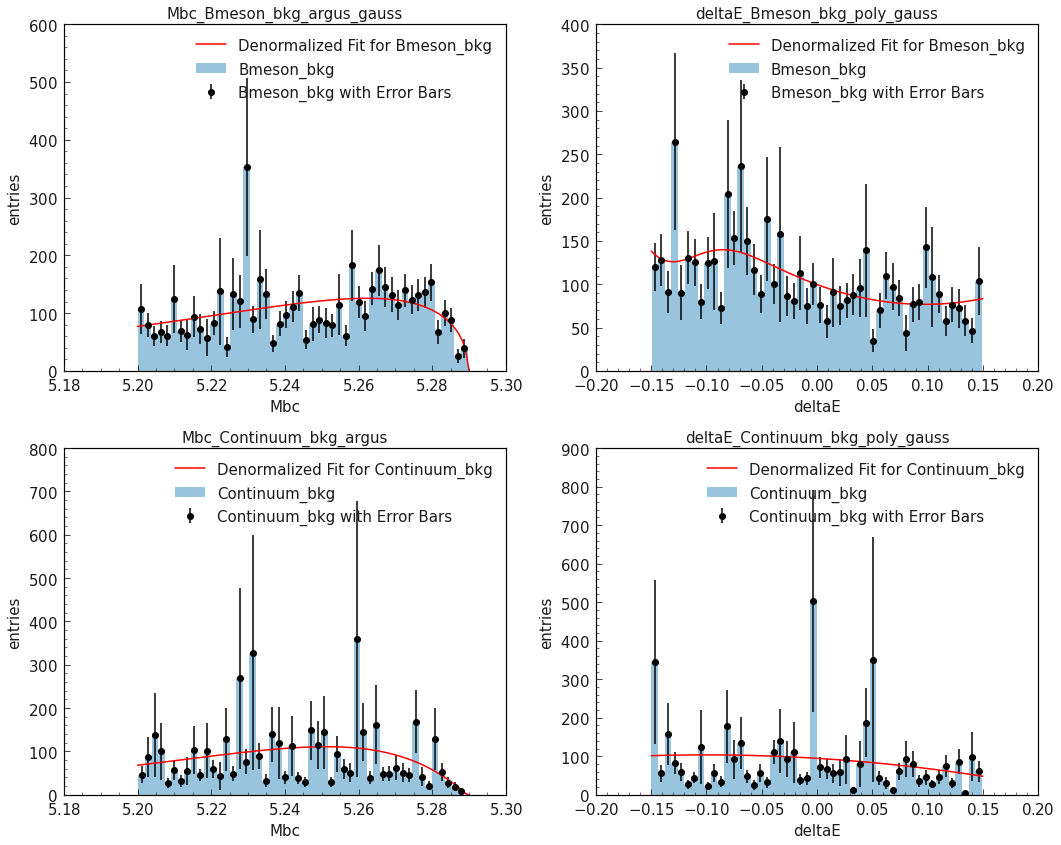

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15,12))  # Changed to 1 row, 2 columns


Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)


fit_model_Mbc_Bmeson_bkg = plot_with_fit(axs[0,0],50, mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight, 
                                         Mbc_Bmeson_bkg_argus_gauss, Mbc_range, 
                                         'Bmeson_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                         'Mbc', 'entries', 'Mbc_Bmeson_bkg_argus_gauss')


fit_model_deltaE_Bmeson_bkg = plot_with_fit(axs[0,1],50, mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,
                                             deltaE_Bmeson_bkg_poly_gauss, deltaE_range, 
                                             'Bmeson_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                             'deltaE', 'entries', 'deltaE_Bmeson_bkg_poly_gauss')

fit_model_Mbc_Continuum_bkg = plot_with_fit(axs[1,0],50, mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight, 
                                         Mbc_Continuum_bkg_argus, Mbc_range, 
                                         'Continuum_bkg', 'Denormalized Fit for Continuum_bkg', 
                                         'Mbc', 'entries', 'Mbc_Continuum_bkg_argus')


fit_model_deltaE_Continuum_bkg = plot_with_fit(axs[1,1],50, mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,
                                             deltaE_Continuum_bkg_poly_gauss, deltaE_range, 
                                             'Continuum_bkg', 'Denormalized Fit for Continuum_bkg', 
                                             'deltaE', 'entries', 'deltaE_Continuum_bkg_poly_gauss')


# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_Bmeson_bkg.params)
print(result_Mbc_Bmeson_bkg.valid)
print(result_deltaE_Bmeson_bkg.params)
print(result_deltaE_Bmeson_bkg.valid)
print(result_Mbc_Continuum_bkg.params)
print(result_Mbc_Continuum_bkg.valid)
print(result_deltaE_Continuum_bkg.params)
print(result_deltaE_Continuum_bkg.valid)


# Show the plots
plt.show()

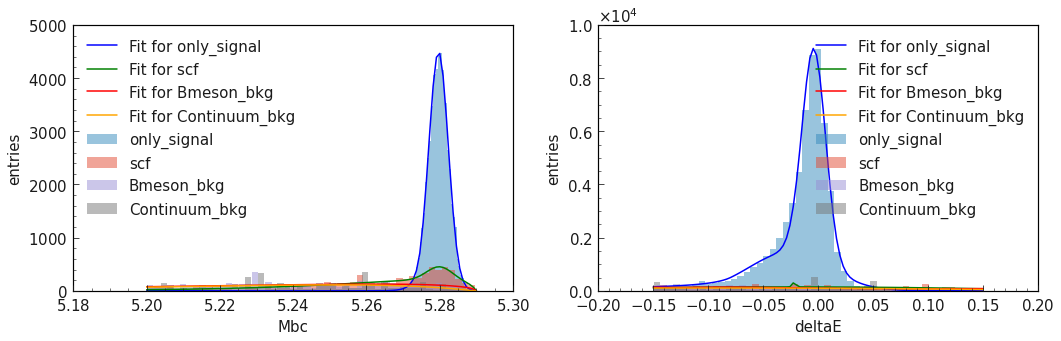

In [15]:
def plot_with_fit(ax, bins, data, data_weight, fitted_model, data_range, label_data, label_fit, xlabel, ylabel, color=None):
    # Calculate histogram
    n, bins, _ = ax.hist(data, bins=bins, weights=data_weight, density=False, alpha=0.5, label=label_data)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((data >= bins[i]) & (data < bins[i+1]))[0]
        bin_weights.append(data_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # De-normalization
    pdf_values = fitted_model.pdf(data_range).numpy() * sum(data_weight) * (bins[1] - bins[0])

    # Plot histogram with error bars and fitted model
    # ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label=f'{label_data} with Error Bars')
    ax.plot(data_range, pdf_values, color=color, label=label_fit)

    # Add labels and title
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    return pdf_values


#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


plot_with_fit(axs[0], 50, mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 
              Mbc_only_signal_cb, Mbc_range, 'only_signal', 'Fit for only_signal', 
              'Mbc', 'entries', color='blue')


plot_with_fit(axs[0], 50, mc_ele_scf["Mbc"], mc_ele_scf_weight, 
              Mbc_scf_argus_gauss, Mbc_range, 'scf', 'Fit for scf', 
              'Mbc', 'entries', color='green')

plot_with_fit(axs[0], 50, mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight, 
              Mbc_Bmeson_bkg_argus_gauss, Mbc_range, 'Bmeson_bkg', 'Fit for Bmeson_bkg', 
              'Mbc', 'entries', color='red')

plot_with_fit(axs[0], 50, mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight, 
              Mbc_Continuum_bkg_argus, Mbc_range, 'Continuum_bkg', 'Fit for Continuum_bkg', 
              'Mbc', 'entries', color='orange')

plot_with_fit(axs[1], 50, mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 
              deltaE_only_signal_cb_gauss, deltaE_range, 'only_signal', 'Fit for only_signal', 
              'deltaE', 'entries', color='blue')

plot_with_fit(axs[1], 50, mc_ele_scf["deltaE"], mc_ele_scf_weight, 
              deltaE_scf_poly_gauss, deltaE_range, 'scf', 'Fit for scf', 
              'deltaE', 'entries', color='green')

plot_with_fit(axs[1], 50, mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,
              deltaE_Bmeson_bkg_poly_gauss, deltaE_range, 'Bmeson_bkg', 'Fit for Bmeson_bkg', 
              'deltaE', 'entries', color='red')

plot_with_fit(axs[1], 50, mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,
              deltaE_Continuum_bkg_poly_gauss, deltaE_range, 'Continuum_bkg', 'Fit for Continuum_bkg', 
              'deltaE', 'entries', color='orange')


# Adjust layout
plt.tight_layout()

## Yield

In [16]:
def fit_fixed(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type,q2reg):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    parameter_df = pd.read_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_{q2reg}.csv")
    
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=True)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    elif model_type == 'cb_gauss':

        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_cb_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)  

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb_fixed, label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)



    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)
        
        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)

    
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.28819 )
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])


  
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed, label_dataset_name_argus_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label
        )
            
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    return label_dataset_name_model_type_fixed
    

# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss_fixed= fit_fixed('Mbc','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight,'argus_gauss',0)
deltaE_Bmeson_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,'poly_gauss',0)


#Continuum_bkg
Mbc_Continuum_bkg_argus_fixed= fit_fixed('Mbc','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight,'argus',0)
deltaE_Continuum_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,'poly',0)

        
        
        
'''   
    data_label_dataset_name = zfit.data.Data.from_pandas(mc_label_particle_type_dataset_name_data, obs=obs_label, weights=mc_label_particle_type_dataset_name_weight)
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type_fixed, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
        
    return label_dataset_name_model_type_fixed, result_label_dataset_name
    

# signal
Mbc_only_signal_cb_fixed,result_Mbc_only_signal = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed,result_deltaE_only_signal = fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed,result_Mbc_scf= fit_fixed('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed,result_deltaE_scf= fit_fixed('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss_fixed,result_Mbc_Bmeson_bkg= fit_fixed('Mbc','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight,'argus_gauss',0)
deltaE_Bmeson_bkg_poly_gauss_fixed,result_deltaE_Bmeson_bkg= fit_fixed('deltaE','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,'poly_gauss',0)


#Continuum_bkg
Mbc_Continuum_bkg_argus_fixed,result_Mbc_Continuum_bkg= fit_fixed('Mbc','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight,'argus',0)
deltaE_Continuum_bkg_poly_gauss_fixed,result_Mbc_only_signal= fit_fixed('deltaE','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,'poly',0)


print(result_Mbc_only_signal.params)
print(result_Mbc_only_signal.valid)
print(result_deltaE_only_signal.params)
print(result_deltaE_only_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)
print(result_Mbc_Bmeson_bkg.params)
print(result_Mbc_Bmeson_bkg.valid)
print(result_deltaE_Bmeson_bkg.params)
print(result_deltaE_Bmeson_bkg.valid)
print(result_Mbc_Continuum_bkg.params)
print(result_Mbc_Continuum_bkg.valid)
print(result_Mbc_only_signal.params)
print(result_Mbc_only_signal.valid)
'''     

'   \n    data_label_dataset_name = zfit.data.Data.from_pandas(mc_label_particle_type_dataset_name_data, obs=obs_label, weights=mc_label_particle_type_dataset_name_weight)\n    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type_fixed, data=data_label_dataset_name)\n    minimizer_label_dataset_name = zfit.minimize.Minuit()\n    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)\n        \n    return label_dataset_name_model_type_fixed, result_label_dataset_name\n    \n\n# signal\nMbc_only_signal_cb_fixed,result_Mbc_only_signal = fit_fixed(\'Mbc\',\'ele\', \'signal\', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,\'cb\',0)\ndeltaE_only_signal_cb_gauss_fixed,result_deltaE_only_signal = fit_fixed(\'deltaE\',\'ele\', \'signal\',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,\'cb_gauss\',0)\n\n\n#scf\nMbc_scf_argus_gauss_fixed,result_Mbc_scf= fit_fixed(\'Mbc\',\'ele\', \'scf\', mc_ele_scf["Mbc"], mc_ele_sc

In [17]:
def fit_extended_model(Mbc_only_signal_pdf,Mbc_scf_pdf, deltaE_only_signal_pdf,deltaE_scf_pdf, Mbc_Bmeson_bkg_pdf,Mbc_Continuum_bkg_pdf, deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf, data, weights):
    
    obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
    obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))
    
    combined_obs = obs_Mbc*obs_deltaE
    
    # Random number for parameter names
    r = np.round(np.random.rand(), decimals=4)
    
    # Signal model
    

    Mbc_signal_pdf = Mbc_only_signal_pdf
    deltaE_signal_pdf = deltaE_only_signal_pdf
    
    signal_product_pdf = zfit.pdf.ProductPDF([Mbc_signal_pdf, deltaE_signal_pdf])
    signal_yield = zfit.Parameter(f"signal_yield_{r}", 1000)
    signal_extended = signal_product_pdf.create_extended(signal_yield)

    # Background model
    frac_Mbc_bkg1 = zfit.Parameter(f'frac_Mbc_bkg1_{r}', 0.5)
    frac_deltaE_bkg1 = zfit.Parameter(f'frac_deltaE_bkg1_{r}', 0.5)
    frac_Mbc_bkg2 = zfit.Parameter(f'frac_Mbc_bkg2_{r}', 0.5)
    frac_deltaE_bkg2 = zfit.Parameter(f'frac_deltaE_bkg2_{r}',0.5)
    
    Mbc_background_pdf = zfit.pdf.SumPDF([Mbc_scf_pdf,Mbc_Bmeson_bkg_pdf, Mbc_Continuum_bkg_pdf], fracs=[frac_Mbc_bkg1,frac_Mbc_bkg2])
    deltaE_background_pdf = zfit.pdf.SumPDF([deltaE_scf_pdf,deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf], fracs=[frac_deltaE_bkg1,frac_deltaE_bkg2])

    background_product_pdf = zfit.pdf.ProductPDF([Mbc_background_pdf, deltaE_background_pdf])
    background_yield = zfit.Parameter(f"background_yield_{r}", 1000)
    background_extended = background_product_pdf.create_extended(background_yield)

    # Total model sum
    total_model = zfit.pdf.SumPDF([signal_extended, background_extended])
    
    # Create a joint data for Mbc and deltaE
    combined_data = zfit.data.Data.from_pandas(data, obs=combined_obs, weights=weights)

    # Create an extended NLL for the model and data
    nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)

    # Minimize the NLL
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result


Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_Bmeson_bkg["Mbc"],mc_ele_Continuum_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_Bmeson_bkg["deltaE"],mc_ele_Continuum_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed, Mbc_scf_argus_gauss_fixed, deltaE_only_signal_cb_gauss_fixed, deltaE_scf_poly_gauss_fixed,
    Mbc_Bmeson_bkg_argus_gauss_fixed,Mbc_Continuum_bkg_argus_fixed,  deltaE_Bmeson_bkg_poly_gauss_fixed,deltaE_Continuum_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight])
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
signal_yield_value = result.params[signal_extended.get_yield()]['value']
background_yield_value = result.params[background_extended.get_yield()]['value']

# Round the values
signal_event_fit = round(signal_yield_value, 3)
bkg_event_fit = round(background_yield_value, 3)


mc_ele_signal_weight = pd.concat([mc_ele_only_signal_weight])
mc_ele_bkg_weight = pd.concat([mc_ele_scf_weight,mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight])

mc_ele_signal_MC = round(sum(mc_ele_signal_weight), 3)
mc_ele_bkg_MC = round(sum(mc_ele_bkg_weight), 3)


# Print the results
print("Results from Fit:")
print("Signal Events =", signal_event_fit)
print("Background Events =", bkg_event_fit)
print()

print("Results from MC Data:")
print("Signal Events in MC Data =", mc_ele_signal_MC)
print("Background Events in MC Data =", mc_ele_bkg_MC)
print()

errors_sig_events = mc_ele_signal_MC - signal_event_fit
print("Signal Events different =", round(errors_sig_events, 3))

errors_bkg_events = mc_ele_bkg_MC - bkg_event_fit
print("Background Events different=", round(errors_bkg_events, 3))


## with fit data ##

In [ ]:
import numpy as np
from uncertainties import ufloat

# Extract signal yield and its error from fit result
signal_yield = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the standard deviation from the given error range
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2


# Create an ufloat for the signal yield with its uncertainty
signal_yield_with_uncertainty = ufloat(signal_yield, signal_yield_error)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = signal_yield_with_uncertainty * (1 + 0.1853)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
Y_B0B0 = ufloat(48.6, 0.6) / 100
BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons) * Y_B0B0)

# PDG value for comparison
central_value = 1.03e-6
average_uncertainty = (0.19e-6 + 0.17e-6) / 2
BR_PDG = ufloat(central_value, average_uncertainty)

# Print results
print("B _to_ee_and_K*_for_electron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)


## BR with MC weights ##

In [ ]:
mc_ele_signal_MC = sum(mc_ele_signal_weight)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = mc_ele_signal_MC * (1 + 0.1853)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
Y_B0B0 = ufloat(48.6, 0.6) / 100
BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons) * Y_B0B0)

# PDG value for comparison
central_value = 1.03e-6
average_uncertainty = (0.19e-6 + 0.17e-6) / 2
BR_PDG = ufloat(central_value, average_uncertainty)

# Print results
print("B _to_ee_and_K*_for_electron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)


In [ ]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for electron.png')
plt.show()


In [ ]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for electron.png')
plt.show()


In [ ]:
def plot_variable(ax, variable, data_only_signal, data_scf, Bmeson_bkg,Continuum_bkg, weight_only_signal, weight_scf, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([ data_scf[variable],Bmeson_bkg[variable],Continuum_bkg[variable]],)
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_only_signal
    bkg_weight = pd.concat([weight_scf,weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.29, 100)
        x_fit = np.linspace(5.20, 5.29, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    #ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.3, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="blue", linewidth=2)

    # Plot the signal component
    #ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red',alpha=0.3,label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="red", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='white',alpha=0.3)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bin_edges) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o',markersize=5, color='black', label='data')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Fit", color="black", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg,mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, mc_ele_Continuum_bkg_weight,
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")

# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for electron.png')
plt.show()